In [2]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [3]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Using data from github to capture all 150 columns
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)
current = pd.read_csv(current_location)

In [4]:
history.shape

(128334, 150)

In [5]:
# Redoing lecture to begin assignment

history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


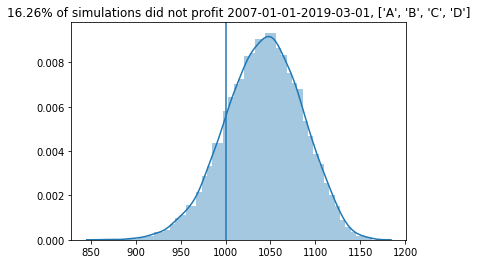

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(n=10000, grades=['A', 'B', 'C', 'D'],
            start_date='2007-01-01',
            end_date='2019-03-01'):
    
    condition = ((history['grade'].isin(grades)) & 
                (history['issue_d'] >= start_date) &
                (history['issue_d'] <= end_date))
    possible = history[condition]
    
    simulations = []
    for _ in tnrange(n):
        picks = possible.sample(40).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    plt.title(f'{percent}% of simulations did not profit {start_date}-{end_date}, {grades}')

simulate()

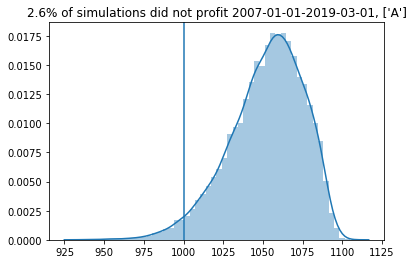

In [8]:
simulate(grades=['A'])

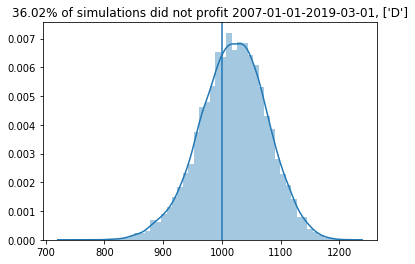

In [9]:
simulate(grades=['D'])

In [8]:
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

In [9]:
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [10]:
features = list(common_columns)
target = 'loan_status'
X = history[features]
y = history[target]

In [11]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=20000,
                                                         stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                 test_size=20000,
                                                 stratify=y_trainval, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((88334, 106), (88334,), (20000, 106), (20000,), (20000, 106), (20000,))

In [12]:
y_train.value_counts(normalize=True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.82485

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'predicted {label}' for label in labels]
    index = [f'actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

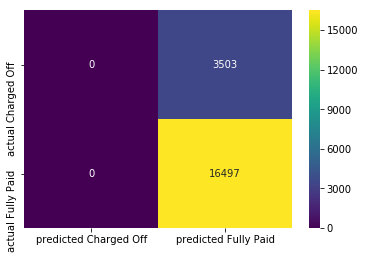

In [17]:
plot_confusion_matrix(y_val, y_pred);

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.51      0.03      0.06      3503
  Fully Paid       0.83      0.99      0.90     16497

   micro avg       0.83      0.83      0.83     20000
   macro avg       0.67      0.51      0.48     20000
weighted avg       0.77      0.83      0.76     20000



In [15]:
from sklearn.metrics import roc_auc_score

y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [16]:
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

,index,0
0,member_id,88334
1,sec_app_mths_since_last_major_derog,87855
2,sec_app_revol_util,86968
3,revol_bal_joint,86954
4,sec_app_collections_12_mths_ex_med,86954
5,sec_app_open_act_il,86954
6,sec_app_mort_acc,86954
7,sec_app_earliest_cr_line,86954
8,sec_app_open_acc,86954
9,sec_app_fico_range_high,86954


In [17]:
many_nulls = null_counts[:73].index
print(list(many_nulls))

['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_open_act_il', 'sec_app_mort_acc', 'sec_app_earliest_cr_line', 'sec_app_open_acc', 'sec_app_fico_range_high', 'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'annual_inc_joint', 'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 'mths_since_rcnt_il', 'total_cu_tl', 'open_il_12m', 'inq_fi', 'inq_last_12m', 'total_bal_il', 'open_acc_6m', 'open_il_24m', 'max_bal_bc', 'open_rv_12m', 'all_util', 'open_rv_24m', 'open_act_il', 'mths_since_last_delinq', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 'avg_cur_bal', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'num_il_tl', 'mo_sin_old_rev_tl_op', 'tot_coll_amt', 'num_tl_30dpd', 'mo_

In [18]:
%%time

def wrangle(X):
    X = X.copy()

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Transform features with many nulls to binary flags
    many_nulls = ['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 
                  'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_mort_acc', 
                  'sec_app_fico_range_high', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 
                  'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'sec_app_open_acc', 
                  'sec_app_earliest_cr_line', 'sec_app_fico_range_low', 'annual_inc_joint', 
                  'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 
                  'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 
                  'mths_since_rcnt_il', 'all_util', 'open_il_12m', 'total_bal_il', 'open_il_24m', 
                  'inq_last_12m', 'open_rv_12m', 'max_bal_bc', 'open_act_il', 'open_rv_24m', 'inq_fi', 
                  'open_acc_6m', 'total_cu_tl', 'mths_since_last_delinq', 'mths_since_recent_inq', 
                  'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 
                  'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op', 'num_actv_bc_tl', 'num_il_tl', 
                  'mo_sin_rcnt_tl', 'total_rev_hi_lim', 'tot_cur_bal', 'num_bc_tl', 'num_tl_30dpd', 
                  'num_op_rev_tl', 'mo_sin_old_rev_tl_op', 'total_il_high_credit_limit', 
                  'num_rev_tl_bal_gt_0', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 
                  'num_tl_op_past_12m', 'num_rev_accts', 'tot_hi_cred_lim', 'tot_coll_amt', 
                  'num_actv_rev_tl', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 
                  'mths_since_recent_bc', 'num_bc_sats', 'num_sats', 'total_bc_limit', 
                  'acc_open_past_24mths', 'total_bal_ex_mort', 'mort_acc', 'title']
    
    for col in many_nulls:
        X[col] = X[col].isnull()
    
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())

    X = X.drop(columns='id')  # id is random
    X = X.drop(columns='member_id')  # member_id is always null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    X = X.drop(columns='zip_code') # High cardinality

    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)
    
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

CPU times: user 3.29 s, sys: 1 s, total: 4.29 s
Wall time: 3.92 s


In [19]:
pd.__version__

'0.23.4'

In [20]:
# conda install pandas=0.23.4
# Wrangle function was throwing error, had to revert to previous Pandas

In [21]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ce.OrdinalEncoder(),
                        RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

pipeline.fit(X_train, y_train)

CPU times: user 35.5 s, sys: 826 ms, total: 36.4 s
Wall time: 13.3 s


In [22]:
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.82505

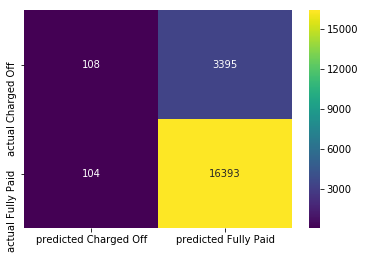

In [23]:
plot_confusion_matrix(y_val, y_pred);

In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.51      0.03      0.06      3503
  Fully Paid       0.83      0.99      0.90     16497

   micro avg       0.83      0.83      0.83     20000
   macro avg       0.67      0.51      0.48     20000
weighted avg       0.77      0.83      0.76     20000



In [27]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.6734485552793266

In [32]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('distribution of predicted probabilities')
    plt.show()
    
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('false positive rate', false_positive_rate)
    print('true positive rate', true_positive_rate)
    
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    print('area under the ROC curve:', roc_auc_score(y_true, y_pred_proba))
    
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, y_true = fixed(y_val), y_pred_proba = fixed(y_pred_proba), 
        threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [35]:
# Playing with class_weight parameter for assignment
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1,
    random_state=None, shuffle=True):
    
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size,
                                                               random_state=random_state,
                                                               shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                     test_size = val_size/(train_size + val_size),
                                                     random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        93
           1       0.50      0.86      0.63         7

   micro avg       0.93      0.93      0.93       100
   macro avg       0.74      0.90      0.80       100
weighted avg       0.95      0.93      0.94       100



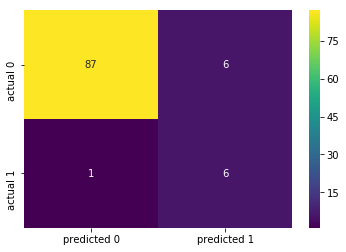

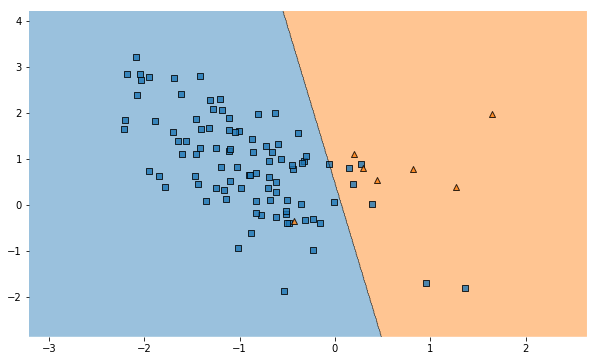

In [39]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

n_samples = 1000
weights = (0.9, 0.1)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                          n_redundant=0, n_repeated=0, n_classes=2, 
                          n_clusters_per_class=1, weights=weights, class_sep=class_sep,
                          random_state=0)

X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X, y,
                                    train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)

class_weight = 'balanced'

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10,6))
plot_decision_regions(X_val, y_val, model, legend=0);

(800, 2)